# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- first name and last name,
    2- first name and last name,
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

### Module Imports

In [2]:
import tarfile
import os
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Extracting data

In [41]:
#extracting tar file

tar_path = os.path.join('./data/', 'project-data.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path='./data/')

### Importing data

In [3]:
data_path = './data/project-data'

#load train images
train_im_path = os.path.join(data_path,'images/train')
im_train_list = [os.path.join(train_im_path,f) for f in os.listdir(train_im_path)\
                 if (os.path.isfile(os.path.join(train_im_path, f)) and f.endswith('.jpg'))]

#load test images
test_im_path = os.path.join(data_path,'images/test')
im_test_list = [os.path.join(test_im_path,f) for f in os.listdir(test_im_path) \
                if (os.path.isfile(os.path.join(test_im_path, f)) and f.endswith('.jpg'))]

#load validation images
validation_im_path = os.path.join(data_path,'images/validation')
im_validation_list = [os.path.join(validation_im_path,f) for f in os.listdir(validation_im_path) \
                      if (os.path.isfile(os.path.join(validation_im_path, f)) and f.endswith('.jpg'))]

im_train = skimage.io.imread_collection(im_train_list)
im_test = skimage.io.imread_collection(im_test_list)
im_val = skimage.io.imread_collection(im_validation_list)



In [4]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [5]:
#load train annotations

train_anno_path = os.path.join(data_path,'annotations/train')
anno_train = [parse_file(os.path.join(train_anno_path,f)) for f in os.listdir(train_anno_path)\
                 if (os.path.isfile(os.path.join(train_anno_path, f)) and f.endswith('.xml'))]

#load test annotations
test_anno_path = os.path.join(data_path,'annotations/test')
anno_test = [parse_file(os.path.join(test_anno_path,f)) for f in os.listdir(test_anno_path)\
                 if (os.path.isfile(os.path.join(test_anno_path, f)) and f.endswith('.xml'))]

#loaf validation annotations
validation_anno_path = os.path.join(data_path,'annotations/validation')
anno_val = [parse_file(os.path.join(validation_anno_path,f)) for f in os.listdir(validation_anno_path)\
                 if (os.path.isfile(os.path.join(validation_anno_path, f)) and f.endswith('.xml'))]


In [102]:
def bbox_to_array(annotations):
    '''returns only the bbox of the annotations in a numpy array'''
    bbox_array = []
    for anno in annotations:
        temp = []
        for bbox in anno:
            temp.append([bbox['bbox'][0], bbox['bbox'][1], bbox['bbox'][2], bbox['bbox'][3]])
        bbox_array.append(temp)
    return np.array(bbox_array)

def plot_images(images, annotations, names, subplots, figsize=(12, 12), bbox=True, bbox_type='dict'):
    '''plotting function
    Input:
        - images: either a single image or a list of images
        - annotations: list image annotations either in the original form dict or as an array for predicted bboxes
        - names: list of image names must be the same size as images
        - subplots: tuple or list of 2 elements specifying subplots organisation must correspond to the number of images
        - figsize: figure size
        - bbox: if true, draws the bbox rectangles
        - bbox_type: specify the annotations structure and type for easier handling
        '''
    
    fig, axes = plt.subplots(subplots[0], subplots[1], figsize=figsize)
    
    if bbox_type == 'dict':
        bbox_array = bbox_to_array(annotations)
    elif bbox_type == 'array':
        bbox_array = annotations
    else:
        raise NotImplementedError
    
    if subplots[0]*subplots[1]>1:
        for ax, im, nm, annotation in zip(axes.ravel(), images, names, bbox_array):
            # Iterate over annotations
            if bbox:
                for anno in annotation:
                    rect = patches.Rectangle((anno[0], anno[1]), anno[2], anno[3],
                            linewidth=1,edgecolor='r',facecolor='none')
                    ax.add_patch(rect)

            ax.imshow(im)
            ax.axis('off')
            ax.set_title(nm)
    
    else:
        if bbox:
            for anno in bbox_array:
                rect = patches.Rectangle((anno[0], anno[1]), anno[2], anno[3],
                        linewidth=1,edgecolor='r',facecolor='none')
                axes.add_patch(rect)
        axes.imshow(images)
        axes.axis('off')
        axes.set_title(names)
    
    plt.show()
    
    

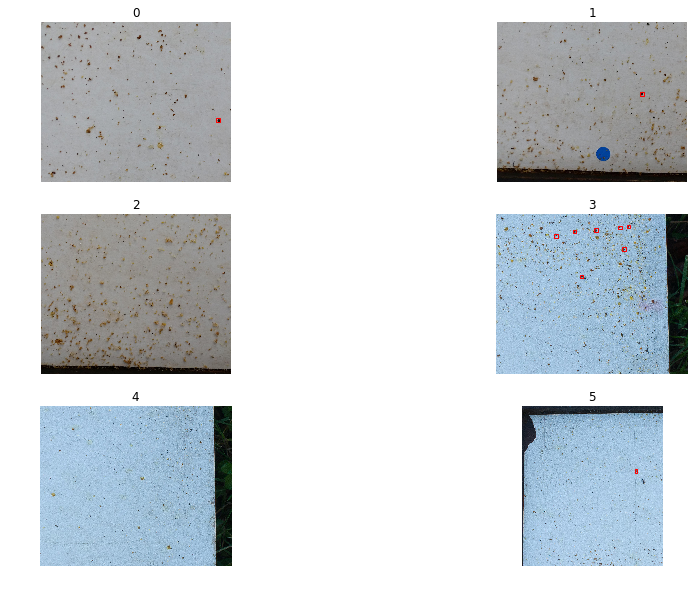

In [103]:
names = [i for i in range(6)]
plot_images(im_train[:6], anno_train[:6], names, [3,2], figsize=(15, 10), bbox=True )


# The following cells are just to check genereal image and boxe sizes. Maybe should be removed for final report

In [104]:
sizes = np.zeros((len(im_train),2))

for i, im in enumerate(im_train):
    sizes[i,0] = im.shape[0]
    sizes[i,1] = im.shape[1]



In [105]:
#checking images sizes 
print('min image size: ', sizes.min(axis=0))
print('max image size: ', sizes.max(axis=0))
print('mean image size: ', sizes.mean(axis=0))
print('stdev image size: ', sizes.std(axis=0))


min image size:  [ 841. 1027.]
max image size:  [1998. 1998.]
mean image size:  [1688.2325 1743.945 ]
stdev image size:  [203.43270618 145.85177227]


min box size:  [4 5]
max box size:  [56 52]
mean box size:  [29.02592543 29.89148737]
stdev box size:  [7.21827986 7.10709102]
min ratio :  0.3125
max ratio :  6.0
max area :  2912
min area :  50


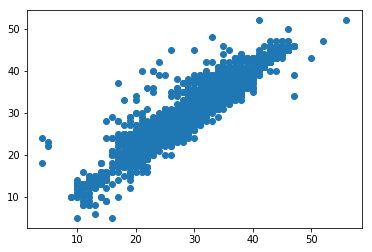

In [106]:
#checking boxes sizes => see some are really elongated
boxes = []
ratio = np.zeros((len(im_train),2))
for i, im in enumerate(anno_train):
    
    for box in im:
        boxes.append([box['bbox'][2], box['bbox'][3]])
        ratio[i] += [box['bbox'][2], box['bbox'][3]]
    if len(im) != 0:
        ratio[i] = sizes[i]/(ratio[i]/len(im))
    else:
        ratio[i] = [0,0]
        
boxes = np.array(boxes)
print('min box size: ', boxes.min(axis=0))
print('max box size: ', boxes.max(axis=0))
print('mean box size: ', boxes.mean(axis=0))
print('stdev box size: ', boxes.std(axis=0))
print('min ratio : ', np.min(boxes[:,1]/boxes[:,0]))
print('max ratio : ', np.max(boxes[:,1]/boxes[:,0]))
print('max area : ', np.max(boxes[:,1]*boxes[:,0]))
print('min area : ', np.min(boxes[:,1]*boxes[:,0]))

plt.scatter(boxes[:,0], boxes[:,1])



In [33]:
np.unique(ratio, return_counts=True)

(array([  0.        ,  29.27777778,  30.81578947, ..., 148.76923077,
        160.41666667, 192.5       ]),
 array([536,   1,   1, ...,   1,   1,   1], dtype=int64))

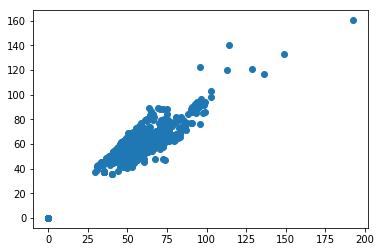

In [34]:
plt.scatter(ratio[:,0], ratio[:,1])

### There are 536 images in 800 with no varroa! 
#### Also, no relation between image sizes and bbox sizes

## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [61]:
#Converting the RGB image to gryscale with luminance
#takes a long time
im_train_g = []
for image in im_train:
    im_train_g.append(skimage.color.rgb2grey(image))

In [100]:
import matplotlib.patches as mpatches

from skimage.filters import threshold_minimum, threshold_local
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, opening
from skimage.color import label2rgb



def detect_by_segmentation(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    #TODO: try to apply different treatment on color channel instead of converting to RGB
    img_grey = skimage.color.rgb2grey(img)
    
    #TODO: try to find better threshold
    thresh = threshold_minimum(img_grey)
    
    #TODO: maybe other operators??
    bw = closing(img_grey < thresh)
    # remove artifacts connected to image border
    cleared = clear_border(bw)


    # label image regions
    label_image = label(cleared)
#    image_label_overlay = label2rgb(label_image, im)
    
    varroa_pred = []
    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= 50 and region.area <= 2912:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            # condition so that elongated regions aren't selected since the regions we want to detect are circular
            if (maxc-minc)/(maxr - minr) > 0.16 and (maxc - minc)/(maxr - minr) < 6:
                rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                          fill=False, edgecolor='red', linewidth=2)
                varroa_pred.append([minc, minr, maxc-minc, maxr-minr])
    
    return np.array(varroa_pred)
    
    

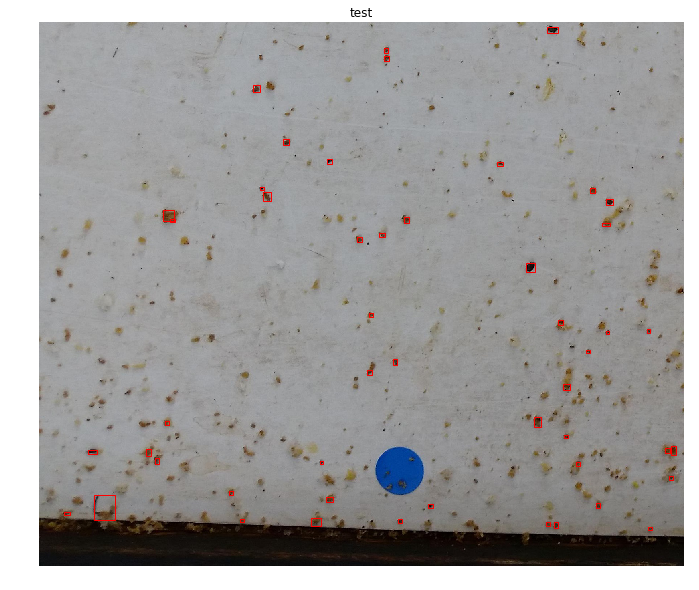

In [101]:
# you can see that it does not work very well! too many false positive => we need to change stuff in segmentation function
a = detect_by_segmentation(im_train[1])
plot_images(im_train[1],a,'test', [1,1], figsize=(15, 10), bbox=True, bbox_type='array' )

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

### IOU, f1 scores etc...

In [107]:
# Here we define the functions we need to calculate the iou of two boxes
# TODO: recheck the overlapp area formula
def overlap_area(box1, box2):
    w = max(min(box1[0]+box1[2] - max(box1[0], box2[0]), box2[0]+box2[2] - max(box1[0], box2[0]), box2[0]+box2[2]),0)
    h = max(min(box1[1]+box1[3] - max(box1[1], box2[1]), box2[1]+box2[3] - max(box1[1], box2[1]), box2[1]+box2[3]),0)
    return w*h

def rect_area(box):
    return box[2]*box[3]

def union_area(box1, box2):
    return rect_area(box1)+rect_area(box2)-overlap_area(box1, box2)

def iou(box1, box2):
    return overlap_area(box1, box2)/union_area(box1, box2)



In [112]:
def calculate_errors(varroa_true, varroa_pred, threshold = 0.3):
    '''
    Calculates the number of true positive, false negative and false positive bewteen the 
    predicted boxes labels and the true ones. 
    '''
    tp = 0
    fn = 0
    fp = 0
    ious = []
    #we iterate over the real labels first in order to count false negatives and true positives
    for i in varroa_true:
        iou_temp = 0
        for j in varroa_pred:
            if iou(i, j) > iou_temp:
                iou_temp = iou(i, j)

        if iou_temp > threshold:
            tp +=1
        else:
            fn += 1
            
    #we also need to iterate over the predicted labels to find the false positive values
    for i in varroa_pred:
        iou_temp = 0
        for j in varroa_true:
            if iou(i,j) > iou_temp:
                iou_temp = iou(i, j)
        
        if iou_temp < threshold:
            fp +=1
    return tp, fn, fp

def give_stats(tp, fn, fp):
    '''
    calculates precision, recall and f1 score from true positive, false negative and false positive values
    '''
    try:
        precision = tp / (tp + fp)
    except ZeroDivisionError:
        precision = 0
    try:
        recall = tp / (tp + fn)
    except ZeroDivisionError:
        recall = 0
    if precision == 0 or recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1


In [113]:
#testing these functions
true = bbox_to_array(anno_train[:6])
for i, im in enumerate( im_train[:6]):
    pred = detect_by_segmentation(im)
    tp, fn, fp = calculate_errors(true[i], pred)
    
    print('Image {}: {} true positive, {} false negative and {} false positive'.format(i+1,tp,fn,fp))
    precision, recall, f1 = give_stats(tp, fn, fp)
    print('          precision = {:.2f}, recall = {:.2f}, f1-score = {:.2f}'.format(precision, recall, f1))

Image 1: 1 true positive, 0 false negative and 116 false positive
          precision = 0.01, recall = 1.00, f1-score = 0.02
Image 2: 1 true positive, 0 false negative and 48 false positive
          precision = 0.02, recall = 1.00, f1-score = 0.04
Image 3: 0 true positive, 0 false negative and 2 false positive
          precision = 0.00, recall = 0.00, f1-score = 0.00
Image 4: 6 true positive, 1 false negative and 133 false positive
          precision = 0.04, recall = 0.86, f1-score = 0.08
Image 5: 0 true positive, 0 false negative and 22 false positive
          precision = 0.00, recall = 0.00, f1-score = 0.00
Image 6: 0 true positive, 1 false negative and 13 false positive
          precision = 0.00, recall = 0.00, f1-score = 0.00


## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

In [3]:
def detect_by_method_1(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [4]:
#Your code

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

In [5]:
#Your code

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [6]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [7]:
#Your code